In [1]:
from data import *
import settings
import pandas as pd
import numpy as np
import seaborn as sns
from scipy.stats import gmean
import matplotlib.pyplot as plt
from matplotlib import ticker

In [2]:
df = load_perf()
df = df.set_index('benchmark').loc[order].reset_index()
df['simulator'] = np.where(df['simulator'] == ours, f'{ours} (ours)', df['simulator'])
sim_order[sim_order.index(ours)] = f'{ours} (ours)'
df['access-per-cycle'] = df['all_data_cache_accesses'] / df['sim-cycles']
df['speed'] = df['sim-cycles'] / df['time']

In [3]:
piv = df.pivot_table(values='access-per-cycle', index='benchmark', columns='simulator')
piv = piv.loc[order]

In [4]:
def fmt_scale(x):
  if np.isnan(x): return '-'
  if x <= 1000: return f'{x:.1f}'
  x /= 1000
  if x <= 1000: return f'{x:.1f} k'
  x /= 1000
  return f'{x:.1f} M'

In [5]:
def mark_npos(bar, y, *args, **kws):
  npos = []
  for c in bar.containers:
    for child in c.get_children():
      if np.isnan(child.get_height()):
        center = child.get_x() + child.get_width() / 2
        npos.append(center)
  xlim = plt.xlim()
  plt.plot(npos, np.full(len(npos), y), *args, **kws)
  plt.xlim(xlim)

In [6]:
def set_hatch(bar):
  hatches = ['//', r"\\", '||', '--', '..']
  for rects, hatch in zip(bar.containers, hatches):
    for r in rects: r.set_hatch(hatch)

In [7]:
piv = df.pivot_table(values='access-per-cycle', index='benchmark', columns='simulator')
gmean((piv['circt-verilator'] - piv[f'{ours} (ours)']) / (piv['circt-verilator']))

0.35985688456163173

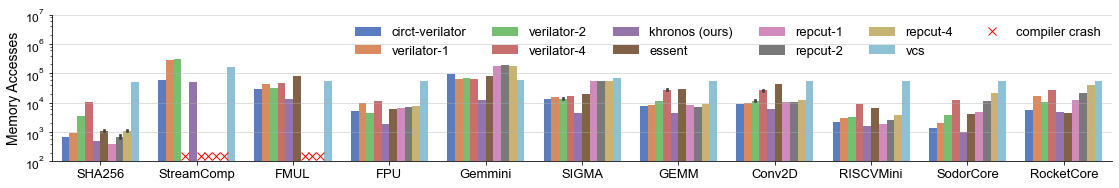

In [8]:
plt.figure(figsize=large_fig_size)
bar = sns.barplot(
  data=df,
  x='benchmark', y='access-per-cycle',
  hue='simulator', hue_order=sim_order,
  palette='muted',
  width=0.8
)
plt.ylim([1e2, 1e7])
mark_npos(bar, 1.5e2, 'rx', markersize=8, label='compiler crash')
plt.xticks(fontsize=13)
plt.xlabel(None)
plt.ylabel('Memory Accesses', fontsize=14)
handles, labels = plt.gca().get_legend_handles_labels()
plt.legend(handles[1:] + handles[:1], labels[1:] + labels[:1], loc='upper right', ncol=6)
sns.despine()
plt.yscale('log')
plt.gca().yaxis.set_major_locator(ticker.LogLocator(base=10, subs=(1,), numticks=100))
plt.gca().yaxis.set_minor_locator(ticker.LogLocator(base=10, subs=(2,4,6,8), numticks=100))
plt.grid(axis='y', which='major', alpha=0.5)
plt.subplots_adjust(left=0.05, right=0.97, bottom=0.2)
plt.savefig('fig/memaccess.pdf')

In [9]:
piv = df.pivot_table(values='speed', index='benchmark', columns='simulator')
baseline = piv[baseline_name].copy()
for col in piv:
  piv[col] /= baseline
piv = piv.stack().reset_index(name='speedup')
piv = piv.set_index('benchmark').loc[order].reset_index()

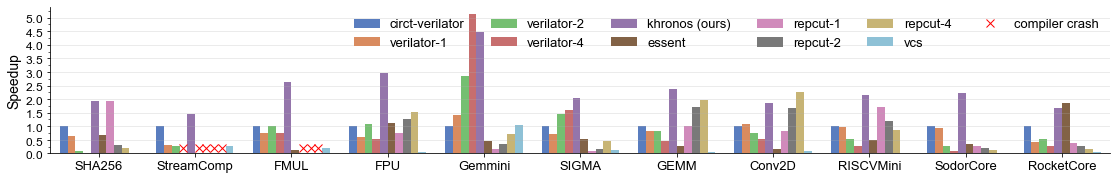

In [10]:
plt.figure(figsize=large_fig_size)
bar = sns.barplot(
  data=piv,
  x='benchmark', y='speedup',
  hue='simulator', hue_order=sim_order,
  palette='muted',
  width=0.8,
)
mark_npos(bar, 0.2, 'rx', markersize=8, label='compiler crash')
handles, labels = plt.gca().get_legend_handles_labels()
plt.legend(handles[1:] + handles[:1], labels[1:] + labels[:1], loc='upper right', ncol=6)
plt.xticks(fontsize=13)
plt.xlabel(None)
plt.ylabel('Speedup', fontsize=14)
ax = plt.gca()
ax.yaxis.set_major_locator(ticker.IndexLocator(base=0.5, offset=0))
ax.yaxis.set_minor_locator(ticker.IndexLocator(base=0.25, offset=0))
plt.grid(axis='y', alpha=0.3)
sns.despine()
plt.subplots_adjust(left=0.05, right=0.97, bottom=0.2)
plt.draw()
plt.savefig('fig/speedup.pdf')